<a href="https://colab.research.google.com/github/jonathanmendoza-tx/Cancer-Project/blob/master/Jonathan_Mendoza_Cancer_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting Survival rate after diagnosis



This dataset was obtained from the National Cancer Institute, and I am using a portion of the dataset which has over a million observations.  My focus will be on the individuals who have been diagnosed with cancer at least one other time, with their most current diagnosis(malignant or benign) being between 1985-2005. I will attempt to estimate how long a person might have lived based on given features. I have labeled the survival lengths of 0-5 years as 'Low', 5-15 years as 'Medium', and 15+ years as 'High.' 

##Load

In [2]:
#number manipulation and plotting imports
import pandas as pd
import numpy as np
!pip install matplotlib==3.1.0
import matplotlib.pyplot as plt
import seaborn as sns

#training imports
from sklearn.model_selection import train_test_split
!pip install -U pandas-profiling
import pandas_profiling
!pip install category_encoders
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

#analysis imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from scipy.stats import randint, uniform
!pip install eli5
import eli5
!pip install pdpbox
from pdpbox.pdp import pdp_isolate, pdp_plot
from eli5.sklearn import PermutationImportance
!pip install shap
import shap


Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)


Using TensorFlow backend.


In [3]:
# Load in and do initial cleaning of dataframe so that it is useable.

df = pd.read_csv('https://raw.githubusercontent.com/jonathanmendoza-tx/Cancer-Project/master/cancer_dataset_csv.csv', low_memory=False, na_values=['Blank(s)','Unknown','Unable to convert'])

df = df[df['Year of diagnosis']<=2005]
df = df[df['Year of diagnosis']>=1985]

#making sure I only have one occurrence per person
df = df.drop_duplicates(subset = 'Patient ID',keep = 'last') 

# dropping rows with NaN values for easier processing. Observations with NaN or 0 for survival months tend to have NaNs in other columns as well.
df = df.dropna(subset = ['Survival months','Recode ICD-O-2 to 9']) 

df['Survival months'] = df['Survival months'].astype('int')
df = df[df['Survival months']!=0]

# cause of death (COD) will leak data, insurance column is empty for this time-period
df = df.drop(labels = ['COD to site recode','SEER cause-specific death classification','Insurance Recode (2007+)'], axis = 1)


# creating target column
survival = pd.cut(df['Survival months'], [0,60,180,503], labels  = ['Low','Medium','High'])

df = df.merge(survival, how = 'left', left_index = True,right_index = True)
df = df.rename(columns={'Survival months_x': 'Survival months','Survival months_y': 'Survival_length'})

#converting object into float
df['Recode ICD-O-2 to 9'] = df['Recode ICD-O-2 to 9'].replace(regex=True,to_replace='_',value='')
df['Recode ICD-O-2 to 9'] = df['Recode ICD-O-2 to 9'].astype('float')

print(df.shape)
df.head()

(100492, 34)


Patient ID  Year of diagnosis  ...  Recode ICD-O-2 to 9 Survival_length
1           3               1985  ...               1623.0          Medium
3         216               1990  ...               1749.0             Low
4         357               2004  ...               1743.0          Medium
7         419               2001  ...               1991.0            High
9         485               1991  ...               1625.0             Low

[5 rows x 34 columns]

In [4]:
train, test = train_test_split(df, train_size=0.8, test_size = 0.2,
                              stratify = df['Survival_length'])
train, val = train_test_split(train, train_size=0.8, test_size = 0.2,
                              stratify = train['Survival_length'])

train.shape,val.shape,test.shape

((64314, 34), (16079, 34), (20099, 34))

In [0]:
train.profile_report()

/usr/local/lib/python3.6/dist-packages/pandas_profiling/model/correlations.py:124: UserWarning: There was an attempt to calculate the cramers correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"cramers": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'The internally computed table of expected frequencies has a zero element at (0, 7).')
  correlation_name=correlation_name, error=error


Based on profiling, features were removed or modified for training model. Explanation in later section. 

##Support Functions

These functions are the basis upon which my analysis begins. I will be using Random Forrest Classifier, along with functions that allow me to describe the model.

In [0]:
def easy_pipeline():
  """Returns a trained random forest pipeline, and prints validation accuracy 
  and classification report when called. Calling this function assumes you 
  have an X_train, y_train, and X_val, y_val"""

  pipeline = make_pipeline(
      ce.OrdinalEncoder(), 
      SimpleImputer(strategy='median'), 
      RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
  )

  pipeline.fit(X_train, y_train)

  print(f'Validation Accuracy: {pipeline.score(X_val, y_val)}')

  y_val_pred = pipeline.predict(X_val)

  print(classification_report(y_val, y_val_pred))

  return pipeline

In [0]:
def plot_confusion_matrix(y_true, y_pred):
  """ Passed actual values and predicted values, returns matrix plot 
      which compares the two and shows how many predictions made per 
      class vs what they actually were"""

  labels = unique_labels(y_true)
  columns = [f'Predicted {label}' for label in labels]
  index = [f'Actual {label}' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                       columns=columns, index=index)
  ax = plt.axes()
  sns.heatmap(table, annot=True, fmt='d', cmap='viridis', ax = ax)
  ax.set_title('Confusion Matrix for Prediction Model')
  plt.show()

  return 

In [0]:
def find_coefficients(pipeline):
  """ Gets feature importance coefficients from passed pipeline"""
  
  importances = pipeline.steps[2][1].feature_importances_
  feat_names = pipeline.steps[0][1].get_feature_names()

  functional_coefficents = pd.Series(
      importances,
      feat_names
  )

  plt.figure(figsize=(10,10))
  functional_coefficents.sort_values().plot.barh();
  plt.title(label='Feature Coefficients of Prediction Model')
  
  return functional_coefficents

In [0]:
def find_eli5_permuter(pipeline, X_train, y_train, X_val, y_val):
  """Eli5 permutation to confirm feature importances"""

  transformer = make_pipeline(
      ce.OrdinalEncoder(),
      SimpleImputer(strategy='mean')
  )

  X_train_transformed = transformer.fit_transform(X_train)
  X_val_transformed = transformer.fit_transform(X_val)

  model = pipeline[2]
  model.fit(X_train_transformed, y_train)

  permuter = PermutationImportance(
      model,
      scoring = 'accuracy',
      n_iter = 5,
      random_state = 42
  )

  permuter.fit(X_val_transformed, y_val)

  return permuter

In [0]:
def eli5_weights(permuter, X):

  feature_names = X.columns.tolist()

  return eli5.show_weights(
          permuter,
          top = None,
          feature_names = feature_names
            )

## Baseline

In [10]:
train['Survival_length'].value_counts(normalize = True)

Medium    0.419100
Low       0.338247
High      0.242653
Name: Survival_length, dtype: float64

Majority class of medium gives a baseline of 41.91% accuracy on the train set

Based on pandas profiling showing 99.7 zeroes for 'Total number of benign/borderline tumors for patient,' the column was dropped from the datasets. 'Patient ID' is not needed in analysis, 'survival months' leaks data and so both are dropped.




In [0]:
target = 'Survival_length'

train_features = train.drop(columns=[target,
                                     'Survival months',
                                     'Patient ID',
                                     'Behavior recode for analysis',
                                     'Total number of benign/borderline tumors for patient'
                                     ]
                            )

features = train_features.select_dtypes(include = 'number').columns.tolist()

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

In [13]:
pipeline0 = easy_pipeline()

Validation Accuracy: 0.7081908078860626
              precision    recall  f1-score   support

        High       0.65      0.77      0.70      3902
         Low       0.71      0.65      0.68      5438
      Medium       0.75      0.72      0.73      6739

    accuracy                           0.71     16079
   macro avg       0.70      0.71      0.71     16079
weighted avg       0.71      0.71      0.71     16079



Here we have a 70.82% baseline accuracy for random forest, against our validation set.

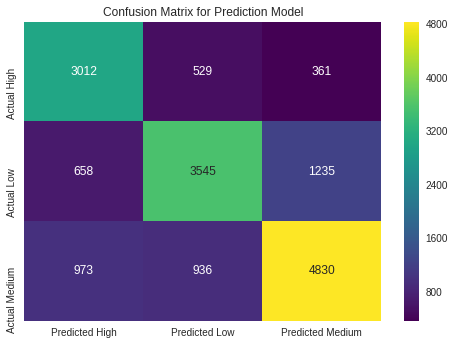

In [14]:
y_val_pred = pipeline0.predict(X_val)
plot_confusion_matrix(y_val, y_val_pred);

According to the confusion matrix and recall/precision metrics, this model is pretty good at predicting if there is a medium or high suvival length

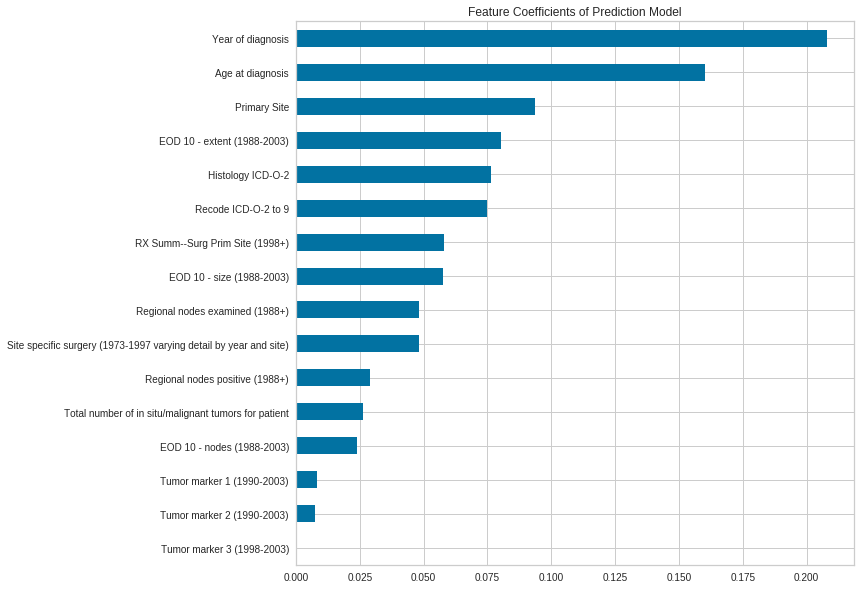

In [15]:
functional_coefficients0 = find_coefficients(pipeline0)

In [18]:
permuter0 = find_eli5_permuter(pipeline0,X_train, y_train, X_val, y_val)
eli5_weights(permuter0,X_train)

Eli5 shows that our dataframe has several features below a zero importance. Those would normally be removed when selecting the features at a later time, but there's something weird going on here. 'Year of diagnosis' seems to be heavily weighed and things like tumor markers have no importance. Logic would say that having a tumor marker should have at least some importance, but lets examine this further.

'Year of diagnosis' might be leaking data. After some research, I found that this result correlates with the CDC data which shows that as the years progress, deaths due to cancer decrease. This is an interesting finding, but the year of diagnosis should not be a factor we base our decisions on if we want to help an individual in real-time. I'll drop the year of diagnosis and now we'll get a true sense of each feature's importance.

In [0]:
target = 'Survival_length'

train_features = X_train.drop(columns=['Year of diagnosis'])

features = train_features.select_dtypes(include = 'number').columns.tolist()

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

In [20]:
pipeline1 = easy_pipeline()

Validation Accuracy: 0.656259717644132
              precision    recall  f1-score   support

        High       0.61      0.55      0.58      3902
         Low       0.69      0.66      0.68      5438
      Medium       0.65      0.71      0.68      6739

    accuracy                           0.66     16079
   macro avg       0.65      0.64      0.65     16079
weighted avg       0.66      0.66      0.66     16079



Baseline without the potentially leaky data is at 65.13%

In [21]:
permuter1 = find_eli5_permuter(pipeline1,X_train, y_train, X_val, y_val)
eli5_weights(permuter1,X_train)

## Improvements on baseline

### Cluster exploration

The following cells were only used during exploratory feature engineering. I was looking for data that has interesting correlations and would cluster nicely. None of these made it past the first feature permutation importance test.

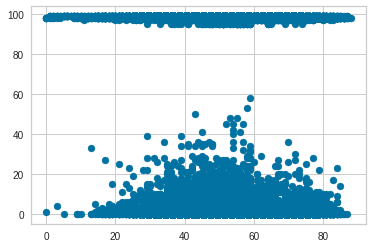

In [0]:
# plt.scatter(train['Age at diagnosis'], train['Regional nodes positive (1988+)'])

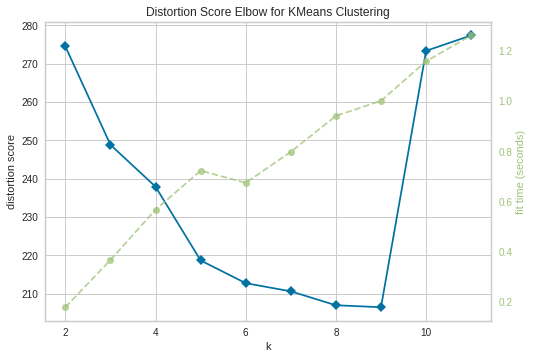

In [0]:
# Did this outside of wrangle to explore, Shows optimal number of clusters equals 8

# train['Regional nodes positive (1988+)'] = train['Regional nodes positive (1988+)'].fillna(method = 'bfill') 
# model = KMeans()
# visualizer = KElbowVisualizer(model, k=(2,12), locate_elbow = True)

# visualizer.fit(train[['Age at diagnosis', 'Regional nodes positive (1988+)']])        # Fit the data to the visualizer
# visualizer.poof()        # Draw/show/poof the data

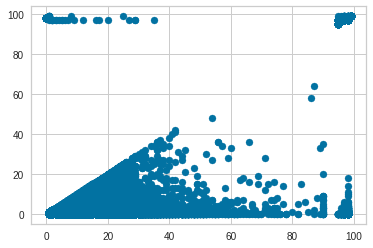

In [0]:
# plt.scatter(train['Regional nodes examined (1988+)'],train['Regional nodes positive (1988+)'])

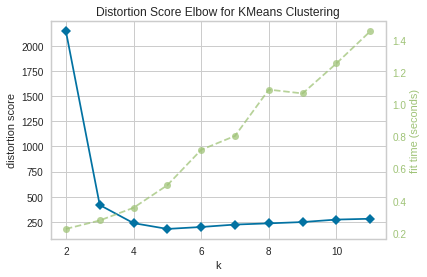

In [0]:
# Did this outside of wrangle, shows best clusters equals 4

# train['Regional nodes positive (1988+)'] = train['Regional nodes positive (1988+)'].fillna(method = 'bfill') 
# train['Regional nodes examined (1988+)'] = train['Regional nodes examined (1988+)'].fillna(method = 'bfill') 


# model = KMeans()
# visualizer = KElbowVisualizer(model, k=(2,12), locate_elbow = True)

# visualizer.fit(train[['Regional nodes positive (1988+)','Regional nodes examined (1988+)']])        # Fit the data to the visualizer
# visualizer.poof()        # Draw/show/poof the data

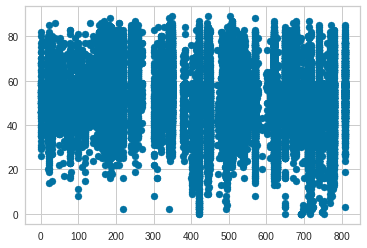

In [0]:
plt.scatter(train['Primary Site'],train['Age at diagnosis'])

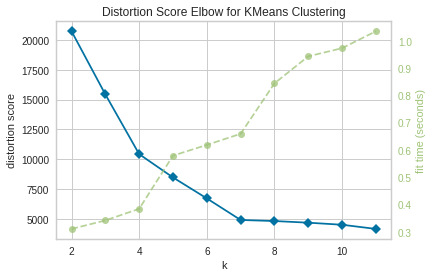

In [0]:
# model = KMeans()
# visualizer = KElbowVisualizer(model, k=(2,12), locate_elbow = True)

# visualizer.fit(train[['Primary Site','Age at diagnosis']])        # Fit the data to the visualizer
# visualizer.poof()        # Draw/show/poof the data

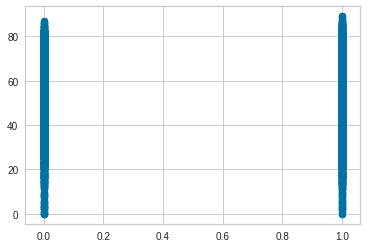

In [0]:
# train['is_female'] = np.where(train['Sex'] == 'Male', 0, 1)
# plt.scatter(train['is_female'],train['Age at diagnosis'])


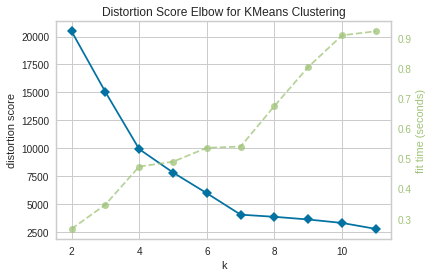

In [0]:
# visualizer = KElbowVisualizer(model, k=(2,12), locate_elbow = True)
# visualizer.fit(train[['is_female','Primary Site']])        # Fit the data to the visualizer
# visualizer.poof()        # Draw/show/poof the data

### Wrangle and refine model

In [0]:
def wrangle(X):

  """ Drop columns with less than zero permutation importance. Recode cancer
  diagnosis based on top 30 cancers in the dataset. Recode hist/behav based 
  on top 50 values, turn sex into binary column. """

  X = X.copy()

  mask = permuter1.feature_importances_ < 0

  cols2drop = X_train.columns[mask]

  X = X.drop(columns = cols2drop)  #dropping features with low coefficients from first run

  top30 = X['CS Schema - AJCC 6th Edition'].value_counts()[:30].index.tolist()

  X['Cancer_recode']= np.where(X['CS Schema - AJCC 6th Edition'].isin(top30) == True, X['CS Schema - AJCC 6th Edition'], 'Other')

  top50 = X['ICD-O-3 Hist/behav'].value_counts()[:50].index.tolist()

  X['Hist/behav_recode'] = np.where(X['ICD-O-3 Hist/behav'].isin(top50) == True, X['ICD-O-3 Hist/behav'], 'Other')

  X['Regional nodes positive (1988+)'] = X['Regional nodes positive (1988+)'].fillna(method = 'ffill')
  X['Regional nodes positive (1988+)'] = X['Regional nodes positive (1988+)'].fillna(method = 'bfill')

  X['is_female'] = np.where(X['Sex'] == 'Male', 0, 1)

  return X

In [0]:
train_wrangled = wrangle(train)
val_wrangled = wrangle(val)
test_wrangled = wrangle(test)

In [0]:
target = 'Survival_length'

train_features = train_wrangled.drop(columns=[target,
                                              'Sex',
                                              'Survival months',
                                              'Patient ID', 
                                              'Year of diagnosis',
                                              'Behavior recode for analysis',
                                              'Total number of benign/borderline tumors for patient'
                                              ]
                                     ) #drop features due to leakage or excess

numeric = train_features.select_dtypes(include = 'number').columns.tolist()

cardinality = train_features.select_dtypes(exclude='number').nunique()

categorical = cardinality[cardinality<=94].index.tolist()

features = numeric + categorical

X_train = train_wrangled[features]
y_train = train_wrangled[target]

X_val = val_wrangled[features]
y_val = val_wrangled[target]

X_test = test_wrangled[features]
y_test = test_wrangled[target]

In [26]:
pipeline2 = easy_pipeline()

Validation Accuracy: 0.6870452142546178
              precision    recall  f1-score   support

        High       0.65      0.55      0.60      3902
         Low       0.72      0.72      0.72      5438
      Medium       0.68      0.74      0.71      6739

    accuracy                           0.69     16079
   macro avg       0.68      0.67      0.68     16079
weighted avg       0.69      0.69      0.69     16079



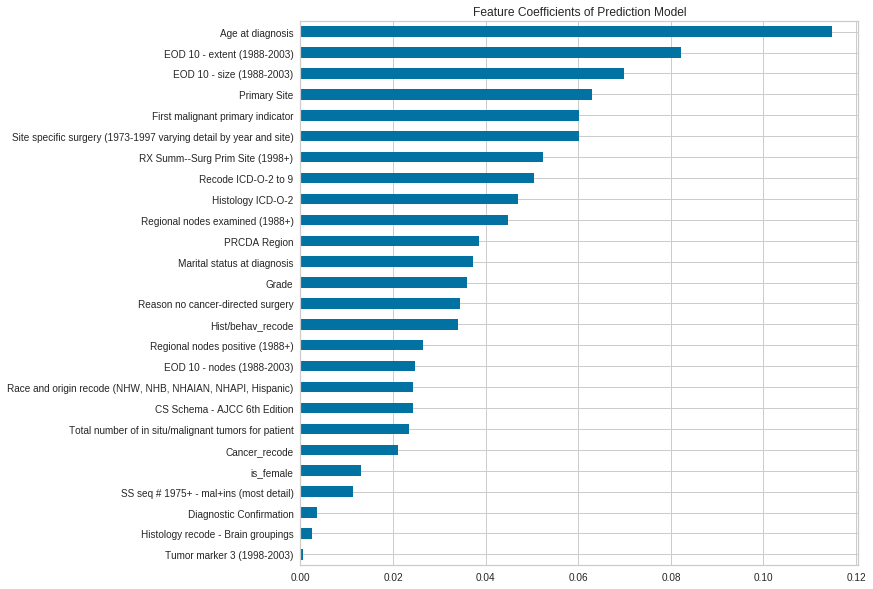

In [27]:
functional_coefficients2 = find_coefficients(pipeline2)

In [29]:
permuter2 = find_eli5_permuter(pipeline2,X_train, y_train, X_val, y_val)
eli5_weights(permuter2,X_train)

In [30]:
mask1 = permuter2.feature_importances_ <= 0

cols2drop1 = X_train.columns[mask1].tolist()

train_features = X_train.drop(columns=cols2drop1) # drop columns which had less than 0 permutation importance

numeric = train_features.select_dtypes(include = 'number').columns.tolist()

cardinality = train_features.select_dtypes(exclude='number').nunique()

categorical = cardinality[cardinality<=94].index.tolist()

features1 = numeric + categorical

X_train = train_wrangled[features1]

X_val = val_wrangled[features1]

X_test = test_wrangled[features1]

pipeline3 = easy_pipeline()

Validation Accuracy: 0.6854281982710367
              precision    recall  f1-score   support

        High       0.65      0.55      0.60      3902
         Low       0.71      0.72      0.72      5438
      Medium       0.68      0.73      0.71      6739

    accuracy                           0.69     16079
   macro avg       0.68      0.67      0.67     16079
weighted avg       0.68      0.69      0.68     16079



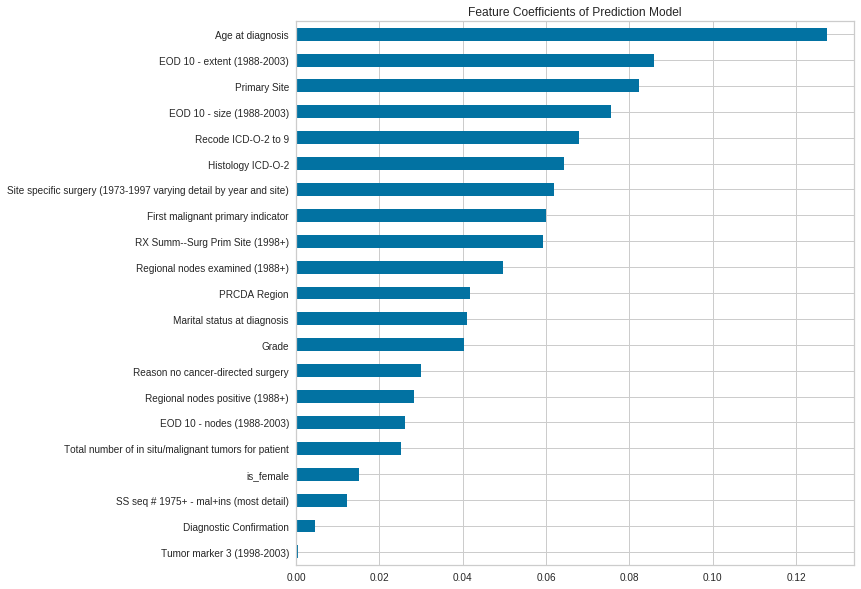

In [31]:
functional_coefficents3 = find_coefficients(pipeline3)

I believe I've done enough feature trimming at this point. Now, I will optimize the hyperparameters for my model in order to get that last bit of accuracy out of my model.

In [32]:
#This cel does a randomized search to tune hyperparameters of random forest regression

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state = 42)
)

param_distributions = { 
    'simpleimputer__strategy': ['mean', 'median','most_frequent'], 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None],
    'randomforestclassifier__min_samples_leaf': randint(5,50),
    'randomforestclassifier__max_features': uniform(0, 1),
    'randomforestclassifier__class_weight':['balanced','balanced_subsample',None]   
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    return_train_score=True,
    verbose = 10,
    n_jobs = -1
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.8min finished


In [33]:
print(f'Best hyperparameters: \n{search.best_params_}\n')
print(f'Cross-validation best accuracy score: \n{search.best_score_}\n')

pipeline_best_rf = search.best_estimator_
pipeline_best_rf.fit(X_train, y_train)

print(f'Validation Accuracy: \n{pipeline_best_rf.score(X_val, y_val)}\n')

y_val_pred = pipeline_best_rf.predict(X_val)

print(classification_report(y_val, y_val_pred))

Best hyperparameters: 
{'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 0.6826606285641277, 'randomforestclassifier__min_samples_leaf': 28, 'randomforestclassifier__n_estimators': 356, 'simpleimputer__strategy': 'mean'}

Cross-validation best accuracy score: 
0.696038187641882

Validation Accuracy: 
0.6989862553641396

              precision    recall  f1-score   support

        High       0.69      0.53      0.60      3902
         Low       0.73      0.73      0.73      5438
      Medium       0.68      0.77      0.72      6739

    accuracy                           0.70     16079
   macro avg       0.70      0.68      0.68     16079
weighted avg       0.70      0.70      0.70     16079



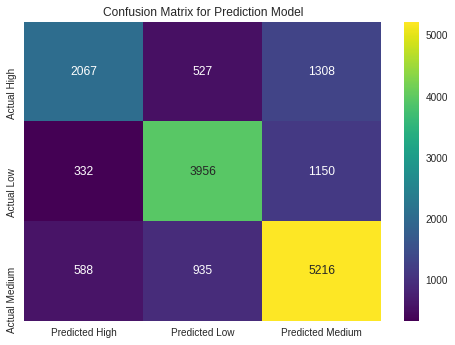

In [34]:
plot_confusion_matrix(y_val, y_val_pred);

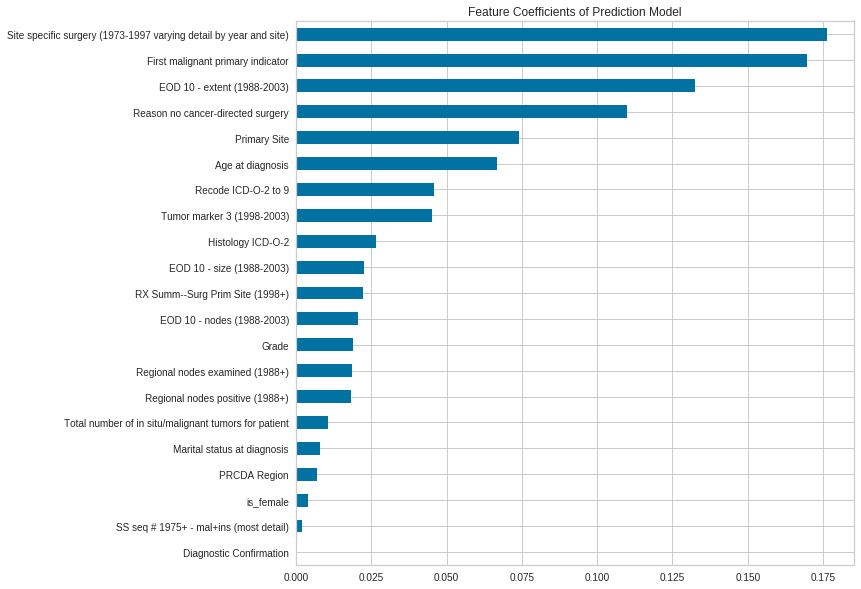

In [35]:
functional_coefficients4 = find_coefficients(pipeline_best_rf)

In [37]:
permuter4 = find_eli5_permuter(pipeline_best_rf, X_train, y_train, X_val, y_val)
eli5_weights(permuter4,X_train)

In [38]:
mask3 = permuter4.feature_importances_ >.015

colstop5 = X_train.columns[mask3].tolist()
colstop5

['Primary Site',
 'Site specific surgery (1973-1997 varying detail by year and site)',
 'EOD 10 - extent (1988-2003)',
 'Tumor marker 3 (1998-2003)',
 'Reason no cancer-directed surgery',
 'First malignant primary indicator']

The top 5 features based on permutation importance. Number one is where surgery was performed, two is whether or not this is the first malignant diagnosis and the third most important feature is the extent of the disease.

## XGBoost

In [0]:
xgb = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators = 100, random_state = 42, n_jobs = -1)
)

xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['CS Schema - AJCC 6th Edition', 'Grade',
                                      'Reason no cancer-directed surgery',
                                      'First malignant primary indicator',
                                      'Race and origin recode (NHW, NHB, '
                                      'NHAIAN, NHAPI, Hispanic)',
                                      'Marital status at diagnosis',
                                      'Histology recode - Brain groupings',
                                      'PRCDA Region', 'Cancer_recode',
                                      'Hist/behav_recode'],
                                drop_invariant=Fa...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                            

In [0]:
y_val_pred_xgb = xgb.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_val_pred_xgb))

print(classification_report(y_val, y_val_pred_xgb))

Validation Accuracy 0.6900926674544436
              precision    recall  f1-score   support

        High       0.70      0.51      0.59      3902
         Low       0.72      0.70      0.71      5438
      Medium       0.66      0.79      0.72      6739

    accuracy                           0.69     16079
   macro avg       0.70      0.67      0.67     16079
weighted avg       0.69      0.69      0.69     16079



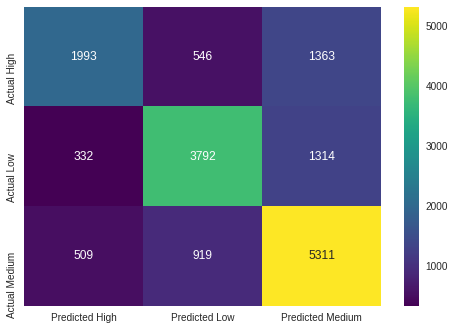

In [0]:
plot_confusion_matrix(y_val, y_val_pred_xgb);

In [0]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.fit_transform(X_val)

eval_set = [(X_train_encoded,y_train),(X_val_encoded,y_val)]

model = XGBClassifier(
    n_estimators = 50,
    max_depth = 6,
    learning_rate = .5,
    n_jobs= - 1
)

model.fit(X_train_encoded, y_train, eval_set = eval_set, eval_metric = 'merror',early_stopping_rounds = 50)

[0]	validation_0-merror:0.319542	validation_1-merror:0.325829
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.314861	validation_1-merror:0.318552
[2]	validation_0-merror:0.310041	validation_1-merror:0.314883
[3]	validation_0-merror:0.306885	validation_1-merror:0.312893
[4]	validation_0-merror:0.303215	validation_1-merror:0.308974
[5]	validation_0-merror:0.299748	validation_1-merror:0.308104
[6]	validation_0-merror:0.296669	validation_1-merror:0.306425
[7]	validation_0-merror:0.294757	validation_1-merror:0.305803
[8]	validation_0-merror:0.293529	validation_1-merror:0.306051
[9]	validation_0-merror:0.291616	validation_1-merror:0.303937
[10]	validation_0-merror:0.289346	validation_1-merror:0.302631
[11]	validation_0-merror:0.287791	validation_1-merror:0.301387
[12]	validation_0-merror:0.284915	validation_1-merror:0.299708
[13]	validation_0-merror:0.2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

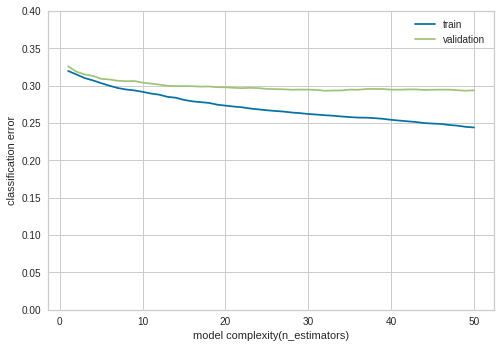

In [0]:
results = model.evals_result()
train_error = results['validation_0']['merror']
val_error = results['validation_1']['merror']

epoch = range(1, len(train_error)+1)
plt.plot(epoch,train_error, label = 'train')
plt.plot(epoch, val_error, label = 'validation')
plt.ylabel('classification error')
plt.xlabel('model complexity(n_estimators)')
plt.ylim(0,.4)
plt.legend();

In [0]:
xgb = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_jobs = -1)
    )

xgb_param_distributions = { 
    'simpleimputer__strategy': ['mean', 'median','most_frequent'], 
    'xgbclassifier__n_estimators': randint(10,35), 
    'xgbclassifier__max_depth': [5, 10, 15, 20, 30],
    'xgbclassifier__learning_rate': uniform(0, 1) 
}

xgb_search = RandomizedSearchCV(
    xgb, 
    param_distributions=xgb_param_distributions, 
    n_iter=10, 
    cv=3, 
    return_train_score=True,
    verbose = 10,
    n_jobs = -1
)

xgb_search.fit(X_train, y_train)

print(f'Best hyperparameters: \n{xgb_search.best_params_}\n')
print(f'Cross-validation best accuracy score: \n{xgb_search.best_score_}\n')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.5min finished


Best hyperparameters: 
{'simpleimputer__strategy': 'most_frequent', 'xgbclassifier__learning_rate': 0.6784176818579157, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 13}

Cross-validation best accuracy score: 
0.6951985570793295



In [0]:
xgb_pipeline = xgb_search.best_estimator_
xgb_pipeline.fit(X_train, y_train)

y_val_pred_xgb = xgb_pipeline.predict(X_val)

print('Validation Accuracy', accuracy_score(y_val, y_val_pred_xgb))

print(classification_report(y_val, y_val_pred_xgb))

Validation Accuracy 0.7004788855028298
              precision    recall  f1-score   support

        High       0.69      0.56      0.62      3902
         Low       0.73      0.72      0.72      5438
      Medium       0.68      0.77      0.72      6739

    accuracy                           0.70     16079
   macro avg       0.70      0.68      0.69     16079
weighted avg       0.70      0.70      0.70     16079



XG boost had similar performance to the random forest model. I will use random forest due to its compatability with feature exploration tools.

## Run best algorithm on test set

Test Accuracy: 
0.6981441862779243

              precision    recall  f1-score   support

        High       0.70      0.54      0.61      4877
         Low       0.72      0.72      0.72      6798
      Medium       0.68      0.77      0.72      8424

    accuracy                           0.70     20099
   macro avg       0.70      0.68      0.69     20099
weighted avg       0.70      0.70      0.70     20099



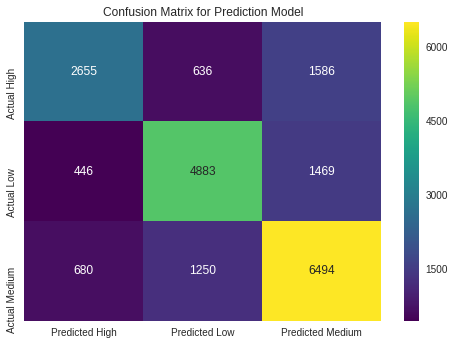

In [39]:
print(f'Test Accuracy: \n{pipeline_best_rf.score(X_test, y_test)}\n')

y_test_pred = pipeline_best_rf.predict(X_test)

print(classification_report(y_test, y_test_pred))

plot_confusion_matrix(y_test, y_test_pred);

Our model on the test set has a 70.06% accuracy! significant improvement over the majority class baseline of 41.9%, and modest improvement on the quick pipeline (65.2%). It has sme trouble distinguishing high survival from medium, but the precision and recall for Low and Medium are satisfactory.

## Other scoring methods

This dataframe shows the predicted values, actual values, and percent probabilities for each target.

In [40]:
predictions = pipeline_best_rf.predict_proba(X_test)

pred_prob = pd.DataFrame(data =predictions)

values = pd.DataFrame(data = y_test).reset_index()

predicted = pd.DataFrame(data = y_test_pred)

pred_df = pd.merge(values, pred_prob, right_index=True, left_index=True )
pred_df = pd.merge(pred_df, predicted, right_index=True, left_index=True)
pred_df = pred_df.rename(columns = {'index':'Patient ID', '0_x':'High', 1:'Low', 2:'Medium', '0_y':'Survival_predicted'})
pred_df = pred_df.reindex(columns=['Patient ID','Survival_length', 'Survival_predicted','Low','Medium','High'])

print(pred_df.shape)

pred_df.head(20)

(20099, 6)


Patient ID Survival_length Survival_predicted       Low    Medium      High
0        78952          Medium             Medium  0.018070  0.981781  0.000149
1        14858             Low                Low  0.636931  0.148313  0.214756
2        16938          Medium             Medium  0.299749  0.481536  0.218715
3       212663          Medium             Medium  0.407495  0.589141  0.003365
4       108771            High             Medium  0.080791  0.563629  0.355580
5       160432             Low                Low  0.838076  0.125895  0.036029
6       214224          Medium             Medium  0.186467  0.812302  0.001231
7       134726          Medium               High  0.009268  0.494696  0.496035
8       203176             Low             Medium  0.197844  0.800918  0.001238
9       176066          Medium             Medium  0.115155  0.547310  0.337535
10      180059          Medium             Medium  0.005074  0.564528  0.430398
11       39478            High               High  0.133632  0.240794  0.625574
12       42412            High               High  0.251651  0.191354  0.556995
13        4925             Low                Low  0.592762  0.291097  0.116141
14      151276            High                Low  0.479398  0.215398  0.305204
15       55974          Medium             Medium  0.303331  0.502222  0.194447
16      126179            High               High  0.172974  0.115148  0.711878
17      100617          Medium             Medium  0.118729  0.587329  0.293942
18      172877            High               High  0.152544  0.264358  0.583098
19      215562            High             Medium  0.018948  0.667074  0.313979

### Shapley values

#### Shapley for patient index 1 of test set



For the first patient in the test set, we see the importance of features visualized. The size of the arrows show which direction the features pushed the prediction. The value represented here is for "Medium" survival length, which is what the model predicted, with a 98% certainity.

In [42]:
transformer = pipeline_best_rf[:-1]

row = X_test.iloc[[0]]

explainer = shap.TreeExplainer(pipeline_best_rf.steps[2][1])

row_process = transformer.transform(row)
shap_values = explainer.shap_values(row_process)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[2],
    shap_values=shap_values[2],
    features=row)

####Shapley for patient index 5 of test set

The shapley values for the fifth patient, which was incorrectly predicted to be "Medium" survival length. This prediction had a 56% certainty. 

In [43]:
row = X_test.iloc[[4]]

row_process = transformer.transform(row)
shap_values = explainer.shap_values(row_process)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[2],
    shap_values=shap_values[2],
    features=row)

### Further Analysis

Case 0 : 'High'

Case 1: 'Low'

Case 2: 'Medium'

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


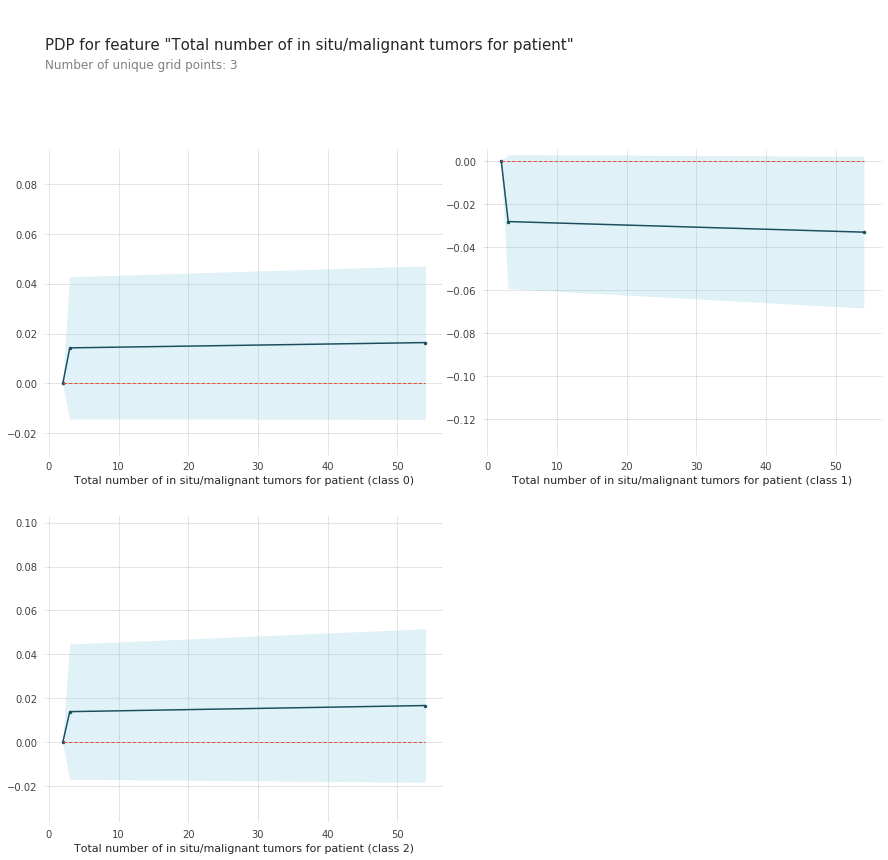

In [0]:
feature = 'Total number of in situ/malignant tumors for patient'

isolated = pdp_isolate(
    model = pipeline_best_rf,
    dataset = X_test,
    model_features=X_test.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

Having more than 1 tumor greatly decreases the survival length of a patient.

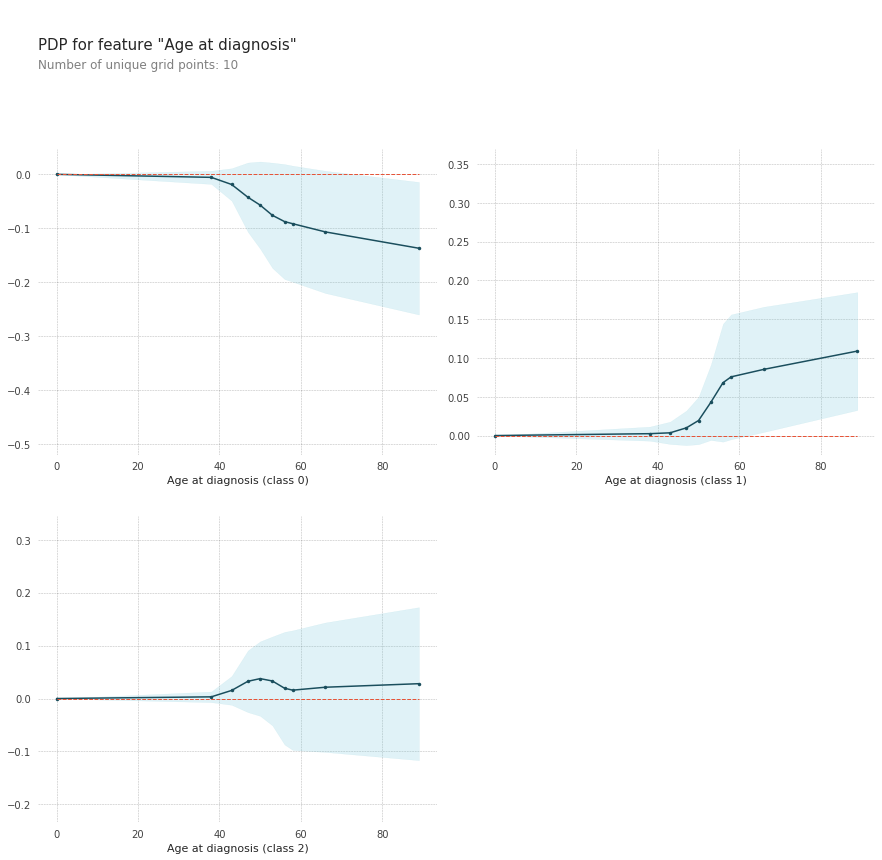

In [0]:
feature = 'Age at diagnosis'

isolated = pdp_isolate(
    model = pipeline_best_rf,
    dataset = X_test,
    model_features=X_test.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

The older you are when diagnosed, the lower your survival length expectancy. There's a significant decrease in life-expectancy between ages 40-60

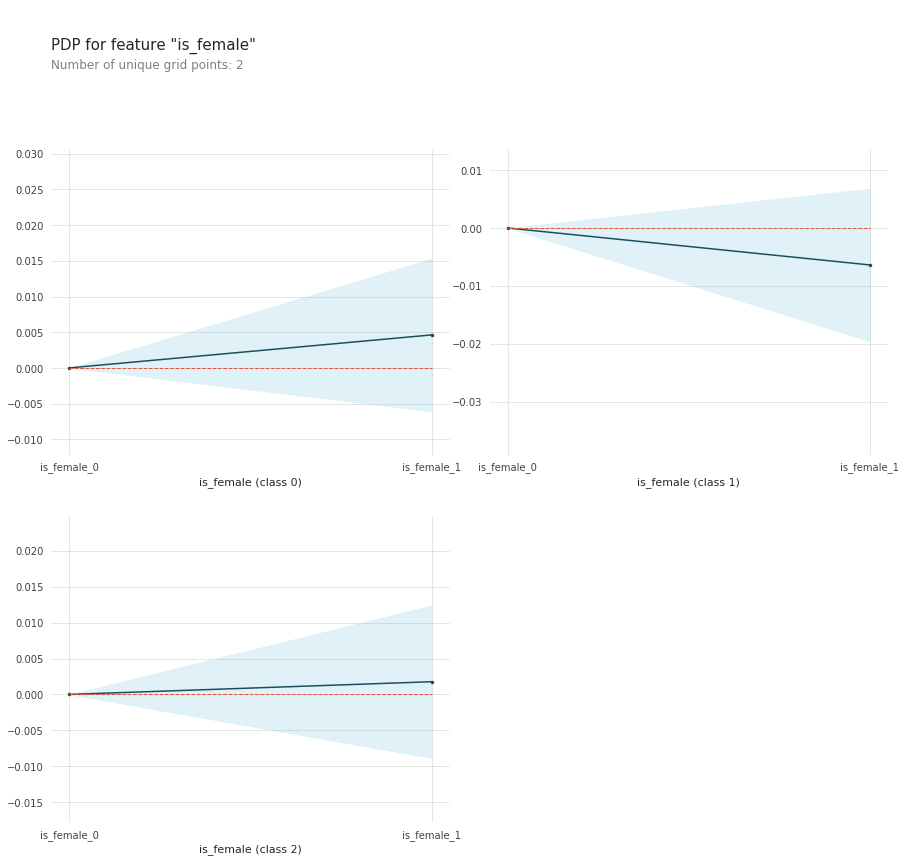

In [0]:
feature ='is_female'
isolated = pdp_isolate(
    model = pipeline_best_rf,
    dataset = X_test,
    model_features=X_test.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

Females have a higher survival length, on average.

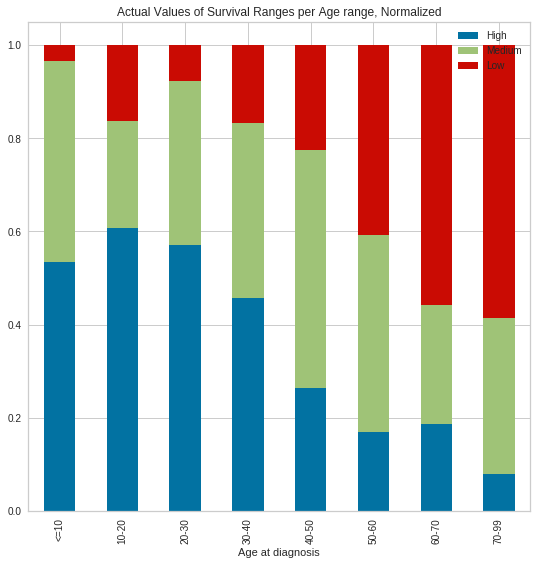

In [49]:
age_bins = pd.cut(test_wrangled['Age at diagnosis'], [-.1,10,20,30,40,50,60,70,99], labels = ['<=10', '10-20','20-30','30-40','40-50','50-60','60-70','70-99'])

survival_age_avgs  = test_wrangled.groupby(age_bins)['Survival_length'].value_counts(normalize = True).unstack()
survival_age_avgs = survival_age_avgs.reindex(columns = ['High','Medium','Low'])

survival_age_avgs.plot.bar(stacked = True, figsize = (9,9)).legend(loc = 'best'),
plt.title(label='Actual Values of Survival Ranges per Age range, Normalized')
plt.show()


Inverse relationship between age at diagnosis and survival length

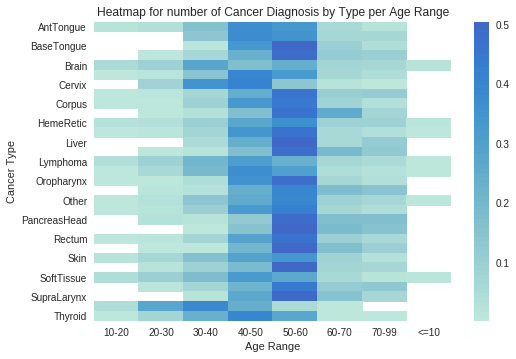

In [50]:
test_wrangled_mod = test_wrangled.merge(age_bins, how = 'left', left_index = True,right_index = True)
test_wrangled_mod = test_wrangled_mod.rename(columns={'Age at diagnosis_x':'Age at diagnosis','Age at diagnosis_y':'age_bin'})

age_cancer  = test_wrangled_mod.groupby('Cancer_recode')['age_bin'].value_counts(normalize = True).unstack()

ax = plt.axes()
sns.heatmap(data = age_cancer, center = True, robust = True, ax = ax)
ax.set_title('Heatmap for number of Cancer Diagnosis by Type per Age Range')
plt.xlabel('Age Range')
plt.ylabel('Cancer Type')
plt.show()

Ages 40-60 are diagnosed more frequently with all cancer types than any other age groups. 

##Conclusions



Years of diagnosis was found to be leaking data, as it was directely correlated to a lower risk for individuals diagnosed later in time. This finding is confirmed  with CDC data on survival rates of cancer patients.

The extent of the disease and age were consistently found to be a top indicators for determining survival range. Ages 40-60 were determined to have the highest rate of malignant diagnosis. This finding leads me to believe that cancer screenings should begin earlier and be done with consistency in order to extend life-expectancy.

Other interesting findings:
* Individuals with more than 1 tumor or more than 1 cancer diagnosis had a much higher risk to their life-expectancy
* Females, on average, have a slightly lower risk to their life expectancy

Predicting the survival range for individuals would be a useful tool for doctors. There may be some intervention that a doctor could take based on the risk of the patients.